# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [4]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

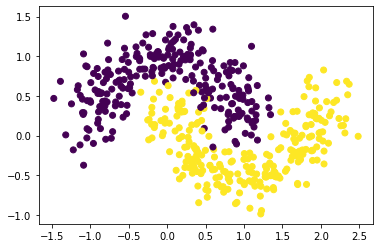

In [5]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

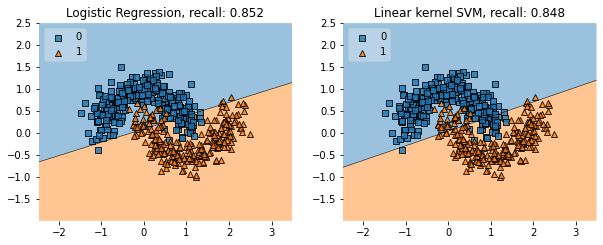

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import recall_score

lr = LogisticRegression(random_state=42) 
svm = SVC(kernel='linear',random_state=42, probability=True) 

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

X = moons_points
y = moons_labels

for clf, lab, grd in zip([lr, svm],
                         ['Logistic Regression', 'Linear kernel SVM'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab + f', recall: {recall_score(y, clf.predict(X))}')
plt.show()



## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

* Качество классификации в сравнении с линейной увеличилось (за исключением сигмоиды, ей на таком датасете плохо)
* Разделяющая поверхность больше не имеет линейный вид
* Для Poly SVM выбрал degree равный 3 т.к. на нем RandomizedSearch показал наивысший recall и он не слишком большой для обобщающей способности классификатора

{'degree': 3}


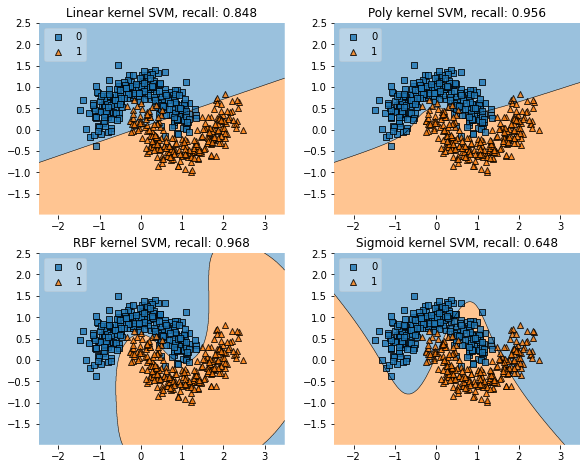

In [107]:
### YOUR CODE HERE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

distributions = dict(degree = range(1,11))

fig = plt.figure(figsize=(15, 12))

svm = [SVC(kernel=ker,random_state=42, probability=True) for ker in ['linear', 'poly', 'rbf', 'sigmoid']]
clfs = [GridSearchCV(svm1, distributions, cv=5, scoring='recall') for svm1 in svm]

X = moons_points
y = moons_labels

for clf, lab, grd in zip(clfs,
                         ['Linear kernel SVM', 'Poly kernel SVM', 'RBF kernel SVM', 'Sigmoid kernel SVM'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab+ f', recall: {recall_score(y, clf.predict(X))}')


print(clfs[1].best_params_)
plt.show()

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

* Сравнивая Poly Logistic Regression и Poly SVM при degree = 3 получаются в целом похожие результаты.
* Имеет смысл и взять degree = 3 т.к. далее ухудшается обобщающая способность, при это recall не сильно растет

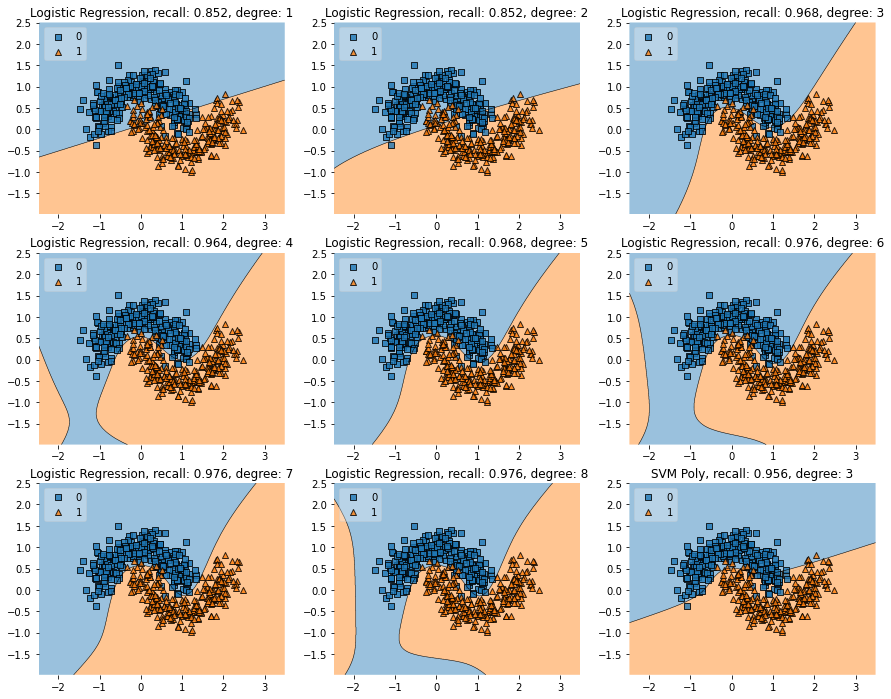

In [103]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

### YOUR CODE HERE
lrs = [make_pipeline(PolynomialFeatures(i), LogisticRegression(random_state=42)) for i in range(1,9)] 
svm = SVC(kernel='poly',random_state=42, degree = 5, probability=True) 

distributions = dict(degree = range(10))

svm = GridSearchCV(svm, distributions, cv=5)

gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(15, 12))

X = moons_points
y = moons_labels
i = 1
for clf, lab, grd in zip(lrs + [svm],
                        ['Logistic Regression']*8 + ['SVM Poly'],
                        itertools.product([0, 1, 2], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab + f', recall: {recall_score(y, clf.predict(X))}, degree: {i if i != 9 else clf.best_params_["degree"]}')
    i+=1
plt.show()

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

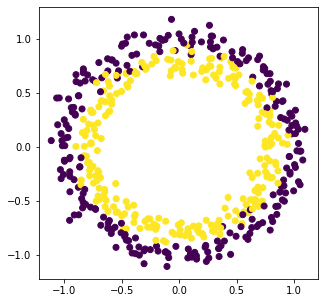

In [108]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

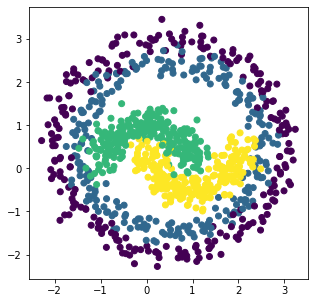

In [109]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

Лучше всего с задачей справились Poly LogReg degree = 4 и SVM с ядром RBF.

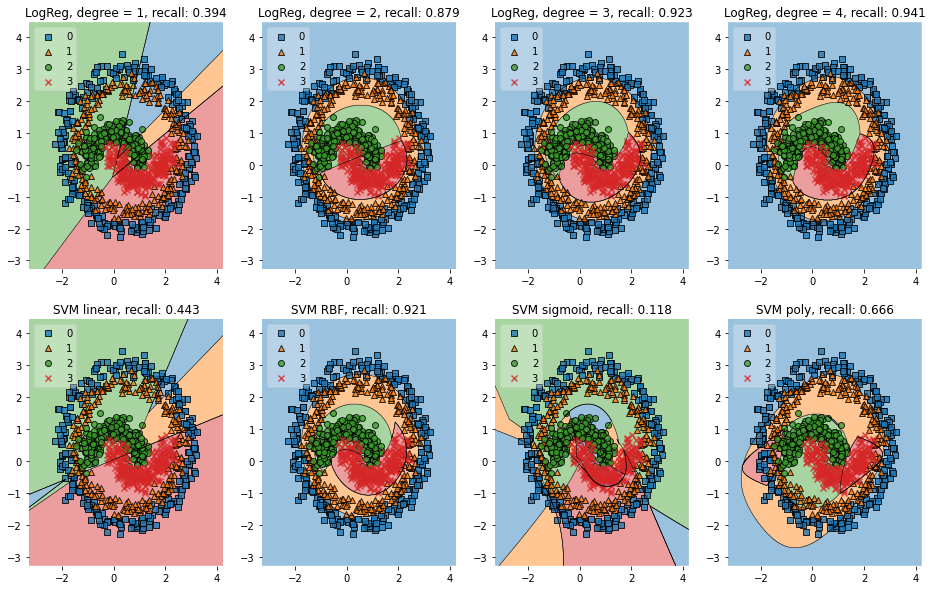

In [135]:
### YOUR CODE HERE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

### YOUR CODE HERE
lrs = [make_pipeline(PolynomialFeatures(i), LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000)) for i in range(1,5)] 
svm = SVC(kernel='poly',random_state=42, probability=True) 

distributions = dict(degree = range(1,10))

svms = [SVC(kernel=ker,random_state=42, probability=True, degree=4) for ker in ['linear', 'rbf', 'sigmoid', 'poly']]

gs = gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(16, 10))

X = points
y = labels
i = 1
for clf, lab, grd in zip(lrs + svms,
                        ['LogReg, degree = 1', 'LogReg, degree = 2',
                        'LogReg, degree = 3', 'LogReg, degree = 4'] + [
                            'SVM linear', 'SVM RBF', 'SVM sigmoid', 'SVM poly'],
                        itertools.product([0, 1, 2, 3], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab + f', recall: {round(recall_score(y, clf.predict(X), average="macro"), 3)}')
    i+=1
plt.show()